In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import unidecode
import re
import numpy as np

In [3]:
# Dicionário de conversão de estados para siglas
estado_para_sigla = {
    "ACRE": "AC", "ALAGOAS": "AL", "AMAPA": "AP", "AMAZONAS": "AM",
    "BAHIA": "BA", "CEARA": "CE", "DISTRITO FEDERAL": "DF", "ESPIRITO SANTO": "ES",
    "GOIAS": "GO", "MARANHAO": "MA", "MATO GROSSO": "MT", "MATO GROSSO DO SUL": "MS",
    "MINAS GERAIS": "MG", "PARA": "PA", "PARAIBA": "PB", "PARANA": "PR",
    "PERNAMBUCO": "PE", "PIAUI": "PI", "RIO DE JANEIRO": "RJ", "RIO GRANDE DO NORTE": "RN",
    "RIO GRANDE DO SUL": "RS", "RONDONIA": "RO", "RORAIMA": "RR", "SANTA CATARINA": "SC",
    "SAO PAULO": "SP", "SERGIPE": "SE", "TOCANTINS": "TO"
}

# Função para normalizar textos (remover acentos e caracteres especiais)
def normalize_text(text):
    text = unidecode.unidecode(text.strip().upper())
    return re.sub(r'[^A-Z\s]', '', text)

# Carregar os dados de queimadas e de saúde
queimadas = pd.read_excel("DadosQueimadas.xlsx")
saude = pd.read_excel("DadosSaude.xlsx")

# Normalizar e corrigir municípios e estados nos dados de queimadas
queimadas['Municipio'] = queimadas['Municipio'].apply(normalize_text)
queimadas['Estado'] = queimadas['Estado'].apply(normalize_text)
queimadas['Estado'] = queimadas['Estado'].map(estado_para_sigla)
queimadas = queimadas.dropna(subset=['Estado', 'Municipio'])

# Normalizar colunas de município e estado no dataset de saúde
saude['ID_MUNICIP'] = saude['ID_MUNICIP'].apply(normalize_text)
saude['SG_UF_NOT'] = saude['SG_UF_NOT'].apply(normalize_text)

# Criar uma coluna de total de sintomas respiratórios no DataFrame de saúde
saude['Total_Casos_Doencas_Respiratorias'] = saude[['TOSSE', 'DISPNEIA', 'DESC_RESP', 'ASMA', 'PNEUMOPATI']].apply(
    lambda x: (x == 1).sum(), axis=1
)

# Adicionar uma coluna para contar cada ocorrência de incêndio
queimadas['Incendios_Contagem'] = 1

# Agrupar os dados de queimadas por Município e Estado, apenas somando a contagem de incêndios e média de dias sem chuva
queimadas_agrupadas = queimadas.groupby(['Municipio', 'Estado']).agg({
    'Incendios_Contagem': 'sum',  # Contagem de incêndios
    'DiaSemChuva': 'mean'          # Média de dias sem chuva
}).reset_index()

# Mesclar os dados de saúde com os dados agregados de queimadas
dados_combinados = pd.merge(saude, queimadas_agrupadas, left_on=['ID_MUNICIP', 'SG_UF_NOT'], right_on=['Municipio', 'Estado'], how='inner')

# Filtrar apenas os estados da região Sudeste
sudeste_estados = ['SP', 'RJ', 'MG', 'ES']
dados_sudeste = dados_combinados[dados_combinados['Estado'].isin(sudeste_estados)]

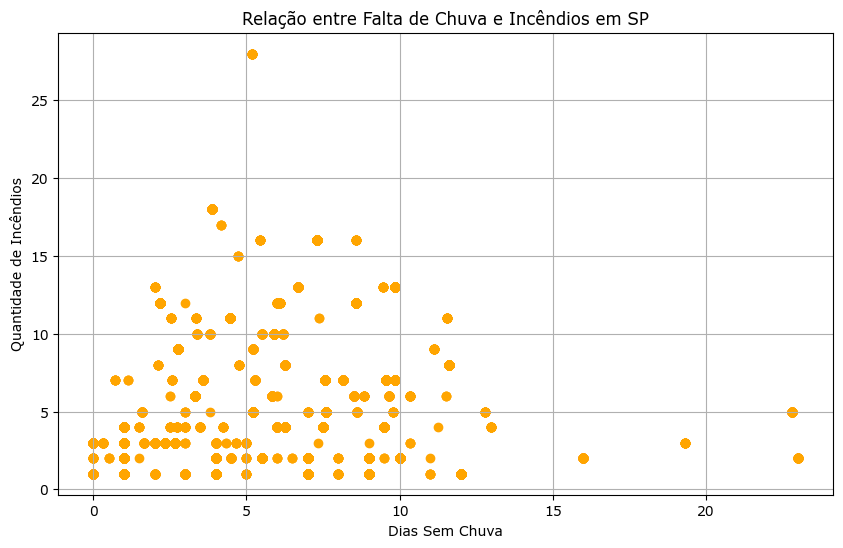

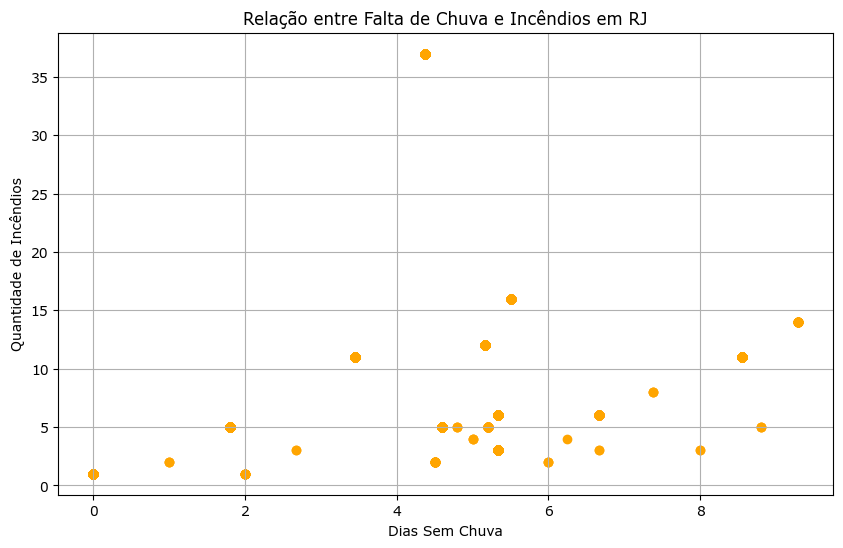

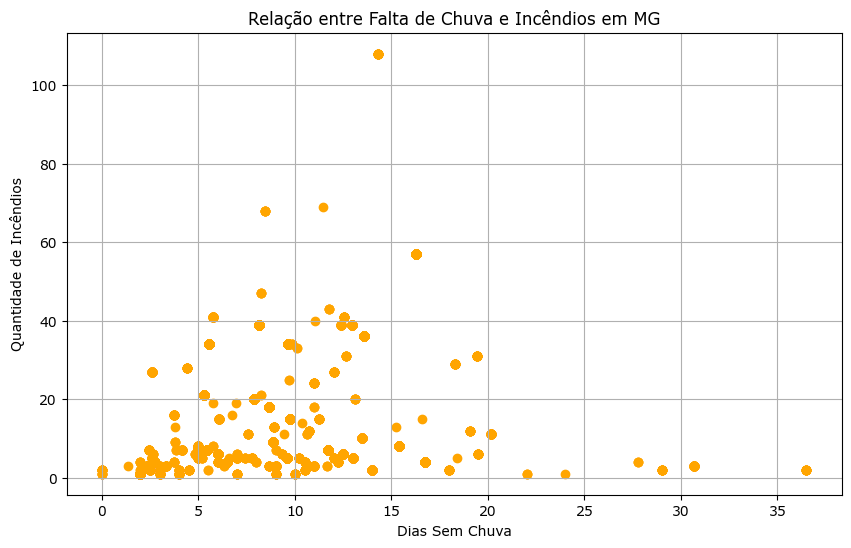

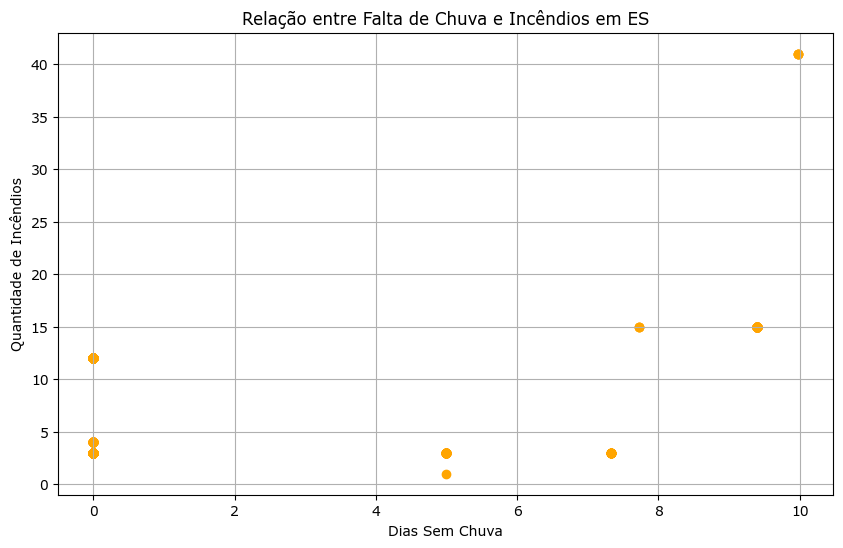

In [4]:

# Criar gráficos de dispersão separados para cada estado
for estado in sudeste_estados:
    dados_estado = dados_sudeste[dados_sudeste['Estado'] == estado]
    
    # Gráfico de Dispersão: Relação entre Falta de Chuva e Incêndios para o estado atual
    plt.figure(figsize=(10, 6))
    plt.scatter(dados_estado['DiaSemChuva'], dados_estado['Incendios_Contagem'], color='orange')
    plt.title(f'Relação entre Falta de Chuva e Incêndios em {estado}')
    plt.xlabel('Dias Sem Chuva')
    plt.ylabel('Quantidade de Incêndios')
    plt.grid()
    plt.show()

In [5]:
# Definindo uma função para agrupar dias sem chuva em intervalos
def agrupar_dias_sem_chuva(dias, intervalo=5):
    return f"{(dias // intervalo) * intervalo}-{((dias // intervalo) + 1) * intervalo - 1}"

dados_sudeste_chuvas = dados_sudeste.copy()

# Adicionando uma nova coluna ao DataFrame com os intervalos de dias sem chuva
dados_sudeste_chuvas.loc[:,'Intervalo_DiasSemChuva'] = dados_sudeste_chuvas['DiaSemChuva'].apply(lambda x: agrupar_dias_sem_chuva(x))

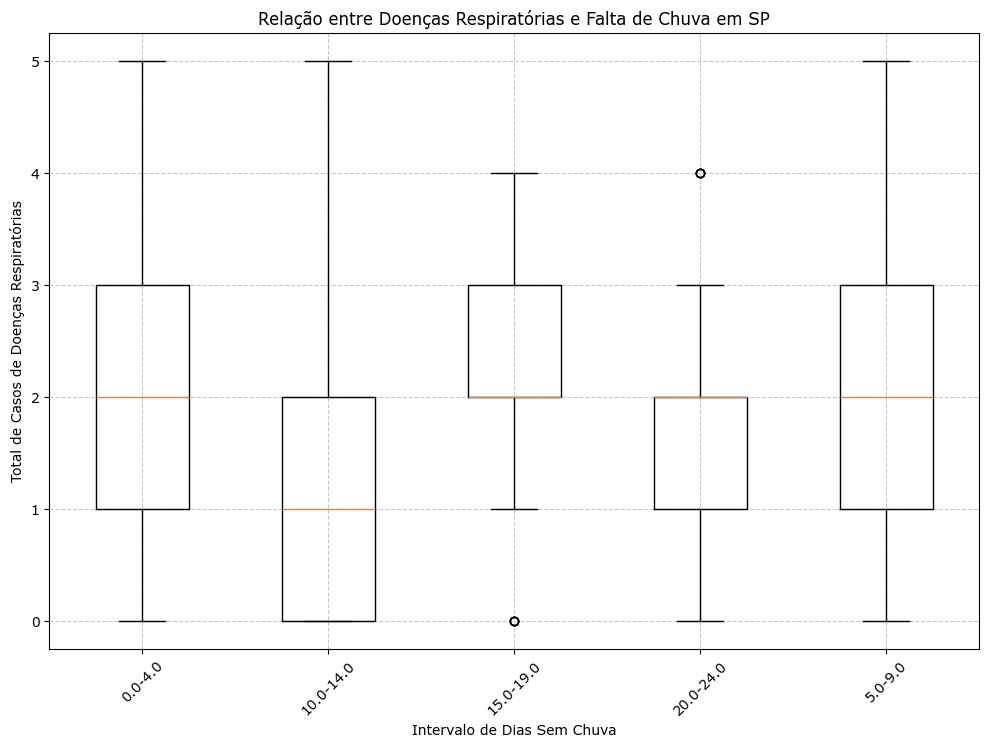

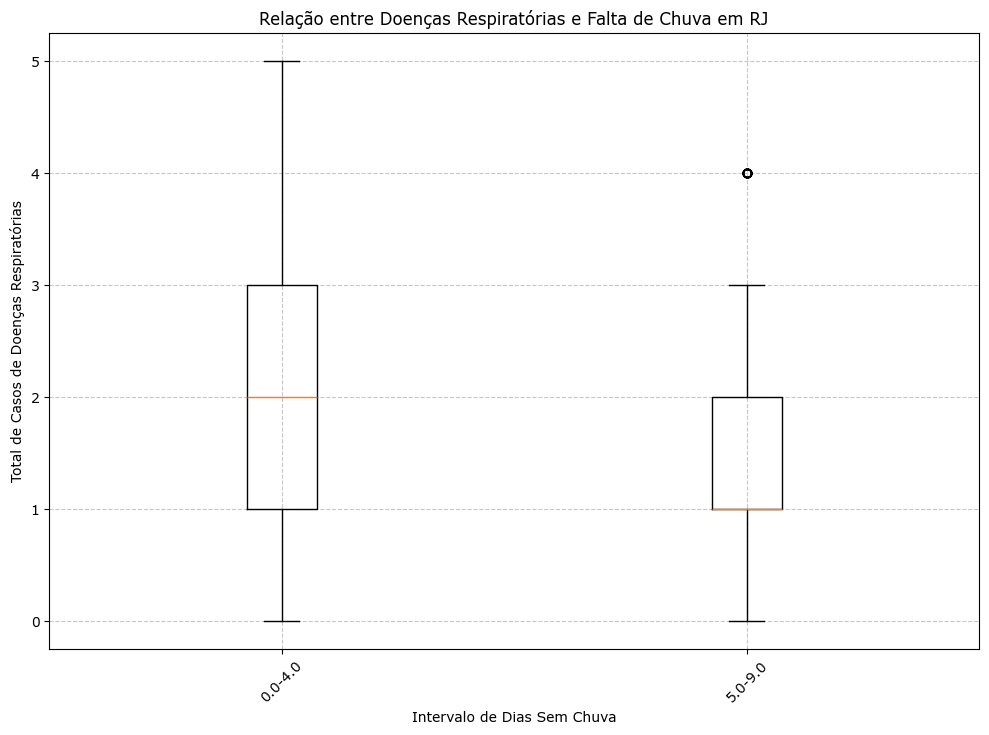

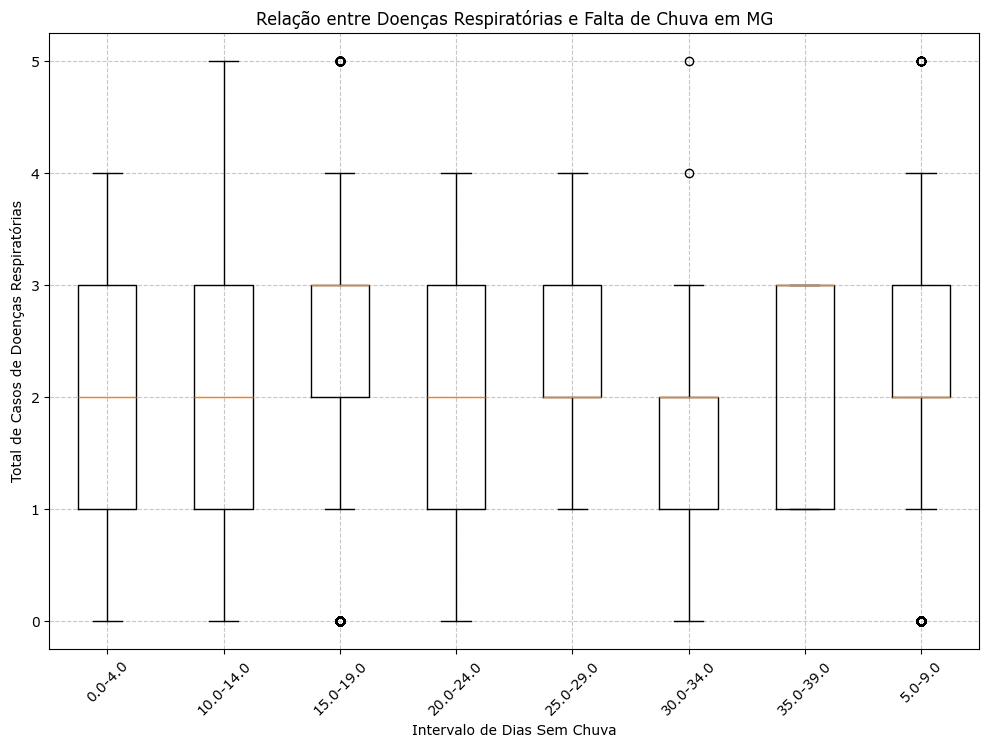

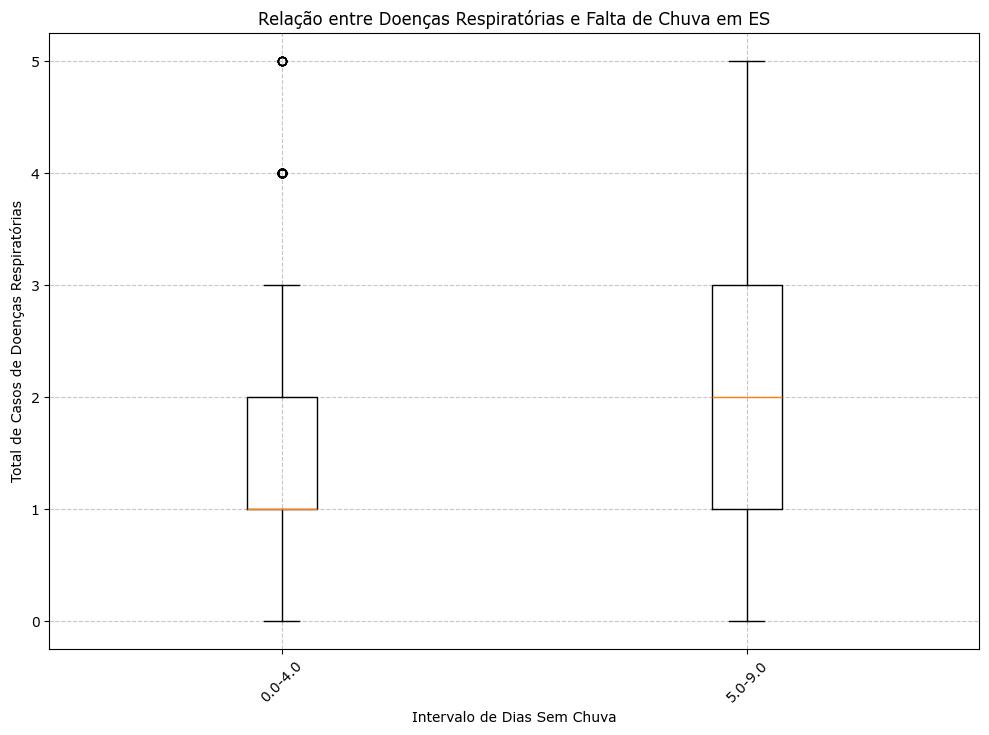

In [6]:
for estado in sudeste_estados:
    # Filtra os dados para o estado atual
    dados_estado = dados_sudeste_chuvas[dados_sudeste_chuvas['Estado'] == estado]

    # Obtenção dos grupos de intervalo de dias sem chuva
    intervalos_unicos = sorted(dados_estado['Intervalo_DiasSemChuva'].unique())
    
    # Criação do box plot: Relação entre Doenças Respiratórias e Falta de Chuva para o estado atual
    plt.figure(figsize=(12, 8))  # Define o tamanho da figura do gráfico
    plt.boxplot(
        # Para cada intervalo de dias sem chuva, seleciona os casos de Doenças Respiratórias
        [dados_estado[dados_estado['Intervalo_DiasSemChuva'] == intervalo]['Total_Casos_Doencas_Respiratorias'] 
         for intervalo in intervalos_unicos],
        
        # Definindo os rótulos do eixo X com os intervalos de dias
        tick_labels=intervalos_unicos
    )

    # Títulos e rótulos dos eixos
    plt.title(f'Relação entre Doenças Respiratórias e Falta de Chuva em {estado}')
    plt.xlabel('Intervalo de Dias Sem Chuva')
    plt.ylabel('Total de Casos de Doenças Respiratórias')
    plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo X para facilitar a leitura
    plt.grid(True, linestyle='--', alpha=0.7)  # Adiciona uma grade ao gráfico

    # Exibir o gráfico
    plt.show()

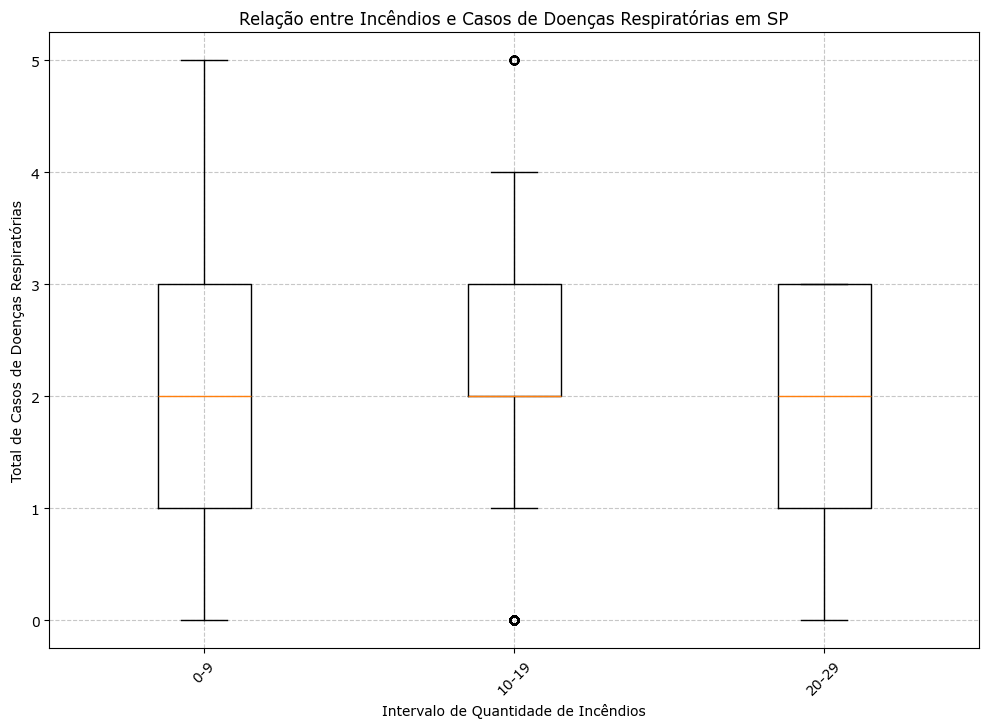

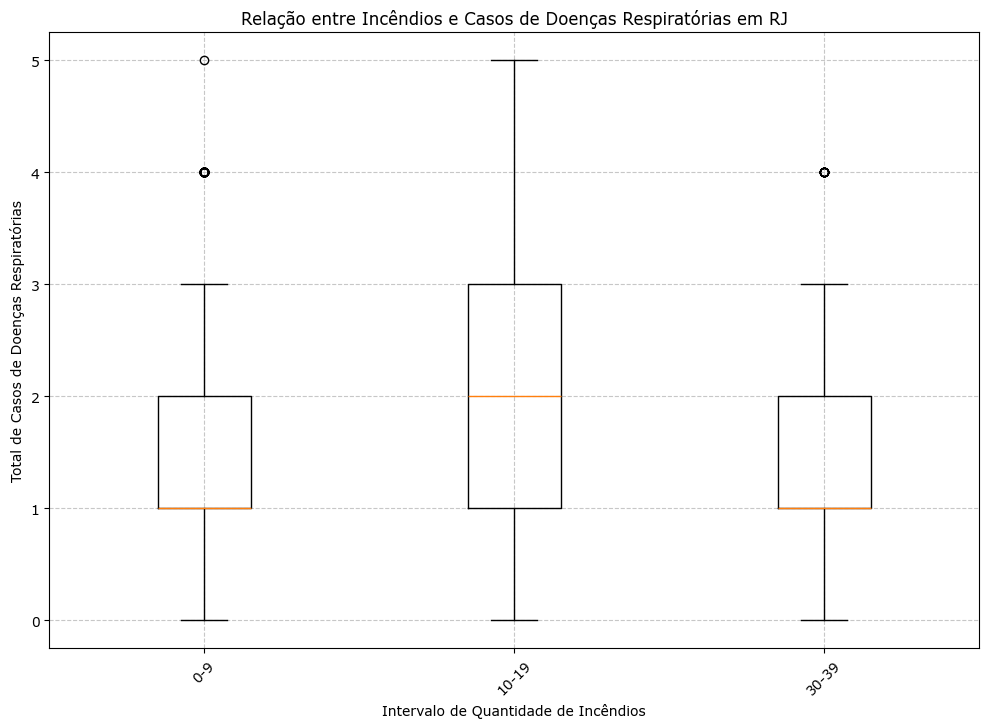

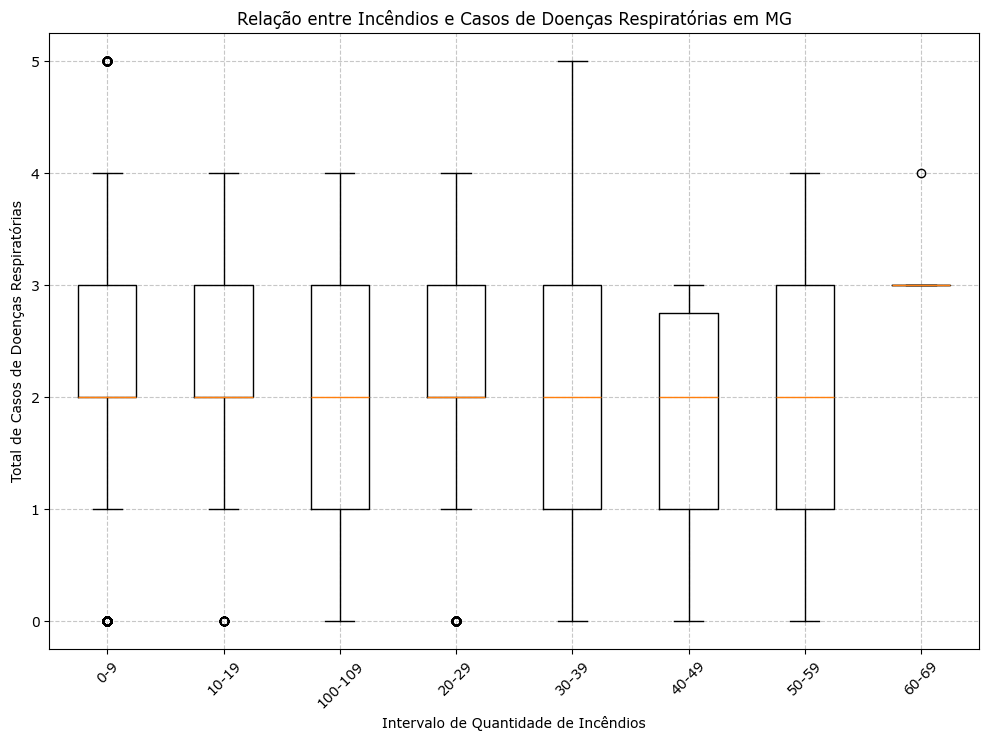

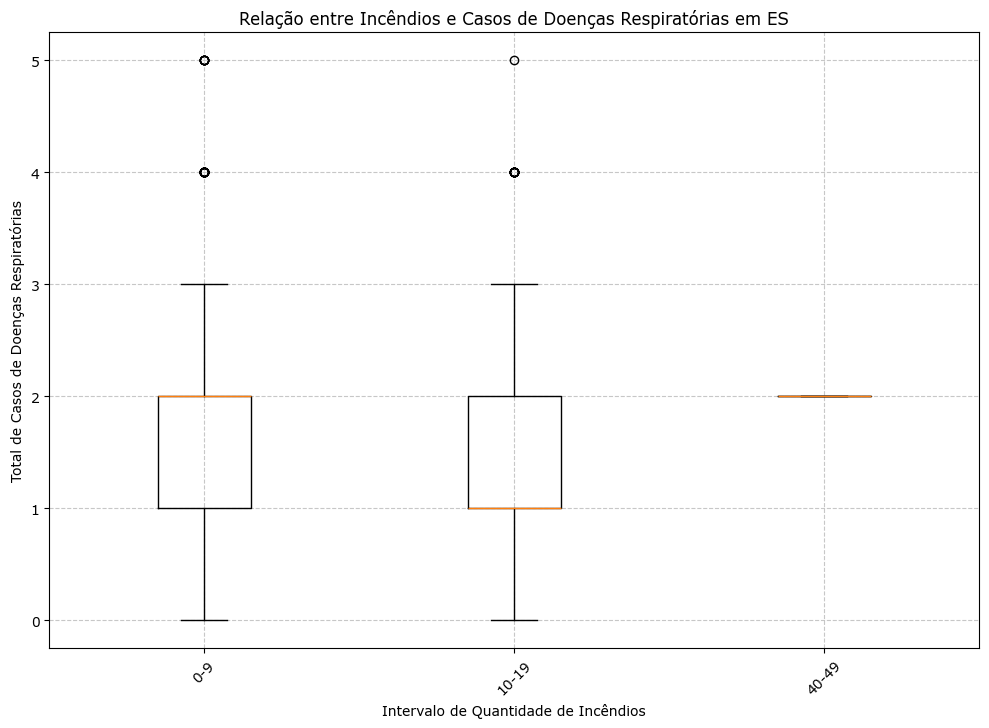

In [7]:
def agrupar_incendios(contagem, intervalo=10):
    return f"{(contagem // intervalo) * intervalo}-{((contagem // intervalo) + 1) * intervalo - 1}"

# Crie uma cópia de dados_sudeste se necessário
dados_sudeste_incendios = dados_sudeste.copy()

# Adicionando uma nova coluna ao DataFrame com os intervalos de contagem de incêndios
dados_sudeste_incendios.loc[:, 'Intervalo_Incendios'] = dados_sudeste_incendios['Incendios_Contagem'].apply(lambda x: agrupar_incendios(x))

for estado in sudeste_estados:
    # Filtra os dados para o estado atual
    dados_estado = dados_sudeste_incendios[dados_sudeste_incendios['Estado'] == estado]

    # Obtenção dos grupos de intervalo de incêndios
    intervalos_unicos = sorted(dados_estado['Intervalo_Incendios'].unique())
    
    # Criação do box plot: Relação entre Incêndios e Doenças Respiratórias para o estado atual
    plt.figure(figsize=(12, 8))  # Define o tamanho da figura do gráfico
    plt.boxplot(
        # Para cada intervalo de incêndios, seleciona os casos de Doenças Respiratórias
        [dados_estado[dados_estado['Intervalo_Incendios'] == intervalo]['Total_Casos_Doencas_Respiratorias'] 
         for intervalo in intervalos_unicos],
        
        # Definindo os rótulos do eixo X com os intervalos de incêndios
        tick_labels=intervalos_unicos
    )

    # Títulos e rótulos dos eixos
    plt.title(f'Relação entre Incêndios e Casos de Doenças Respiratórias em {estado}')
    plt.xlabel('Intervalo de Quantidade de Incêndios')
    plt.ylabel('Total de Casos de Doenças Respiratórias')
    plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para facilitar a leitura
    plt.grid(True, linestyle='--', alpha=0.7)  # Adiciona uma grade ao gráfico

    # Exibir o gráfico
    plt.show()



In [16]:
# Definindo a função para agrupar dias sem chuva em intervalos, caso ainda não tenha sido feita
def agrupar_dias_sem_chuva(dias, intervalo=5):
    return f"{(dias // intervalo) * intervalo}-{((dias // intervalo) + 1) * intervalo - 1}"

# Certificando-se de que a coluna Intervalo_DiasSemChuva existe
if 'Intervalo_DiasSemChuva' not in dados_sudeste.columns:
    dados_sudeste['Intervalo_DiasSemChuva'] = dados_sudeste['DiaSemChuva'].apply(agrupar_dias_sem_chuva)


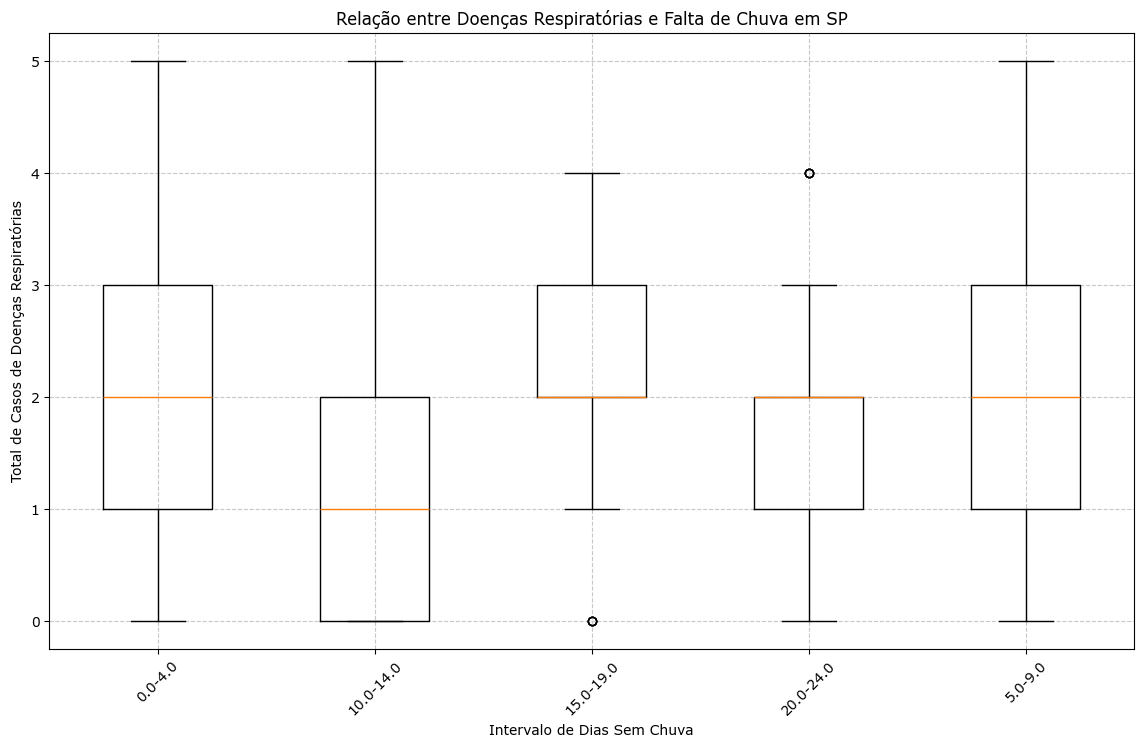

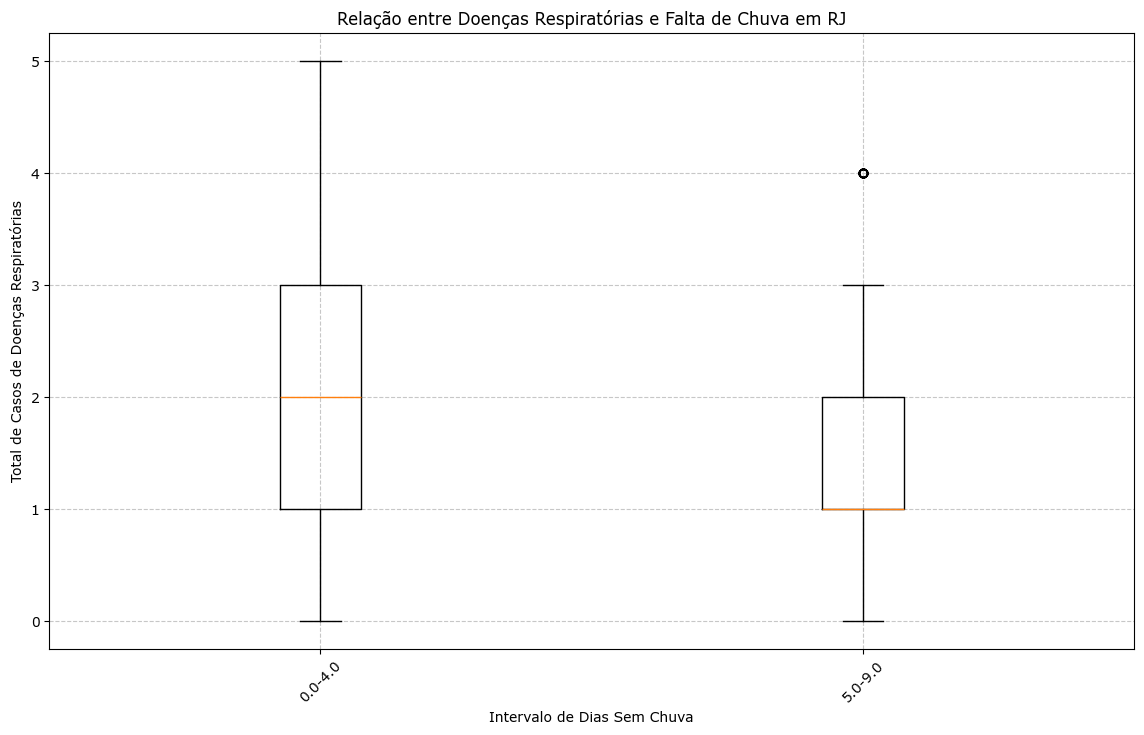

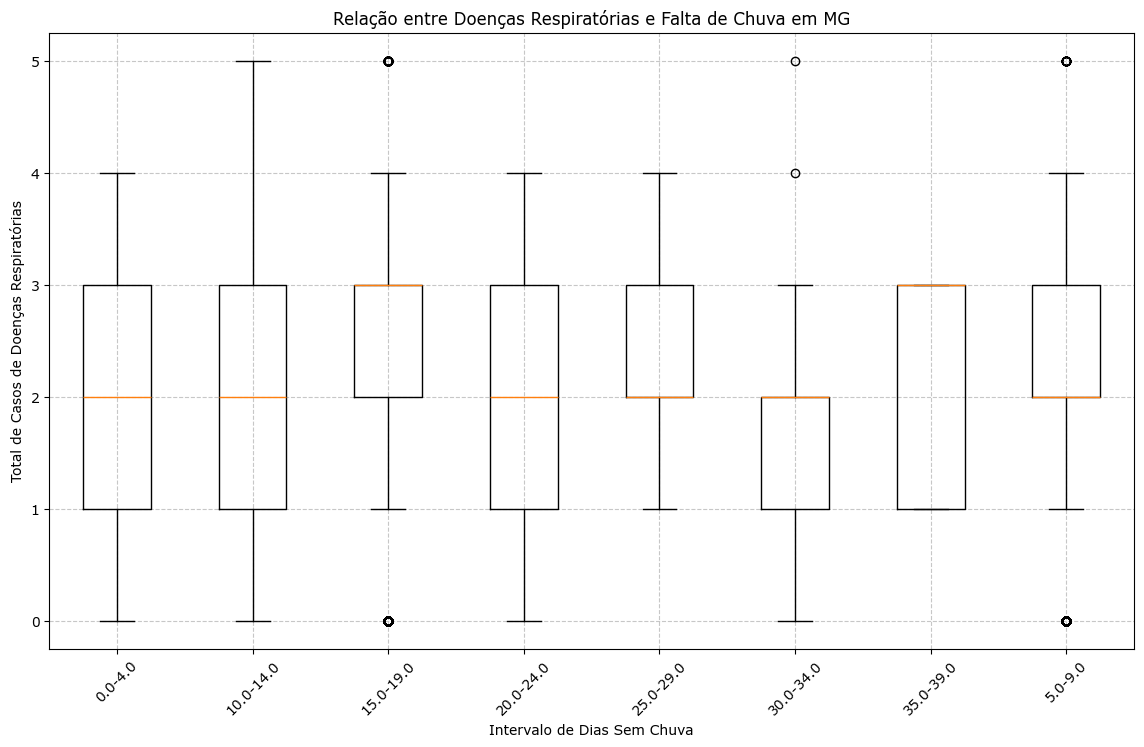

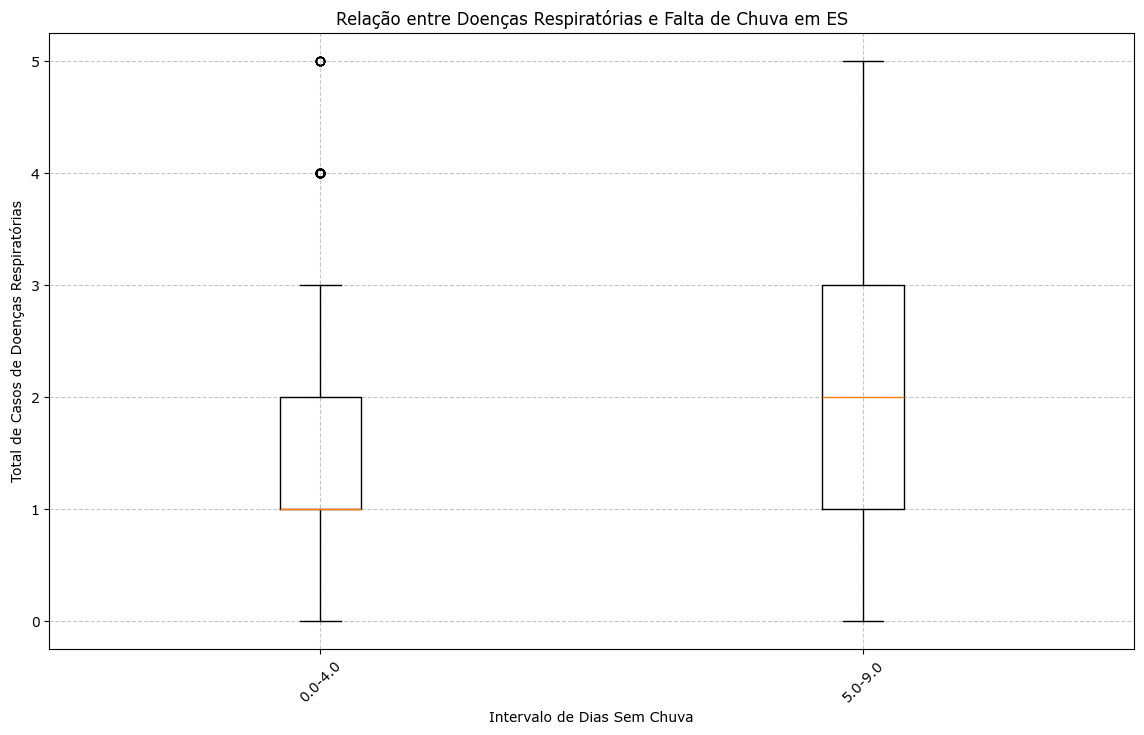

In [17]:
for estado in sudeste_estados:
    # Filtra os dados para o estado atual
    dados_estado = dados_sudeste[dados_sudeste['Estado'] == estado]

    # Obtenção dos grupos de intervalo de dias sem chuva
    intervalos_unicos = sorted(dados_estado['Intervalo_DiasSemChuva'].unique())
    
    # Criação do boxplot: Relação entre Doenças Respiratórias e Falta de Chuva para o estado atual
    plt.figure(figsize=(14, 8))  # Define o tamanho da figura do gráfico
    plt.boxplot(
        # Para cada intervalo de dias sem chuva, seleciona os casos de Doenças Respiratórias
        [dados_estado[dados_estado['Intervalo_DiasSemChuva'] == intervalo]['Total_Casos_Doencas_Respiratorias'] 
         for intervalo in intervalos_unicos],
        
        # Definindo os rótulos do eixo X com os intervalos de dias
        tick_labels=intervalos_unicos  # Corrigido o parâmetro 'labels' para 'tick_labels'
    )

    # Títulos e rótulos dos eixos
    plt.title(f'Relação entre Doenças Respiratórias e Falta de Chuva em {estado}')
    plt.xlabel('Intervalo de Dias Sem Chuva')
    plt.ylabel('Total de Casos de Doenças Respiratórias')
    plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para facilitar a leitura
    plt.grid(True, linestyle='--', alpha=0.7)  # Adiciona uma grade ao gráfico

    # Exibir o gráfico
    plt.show()

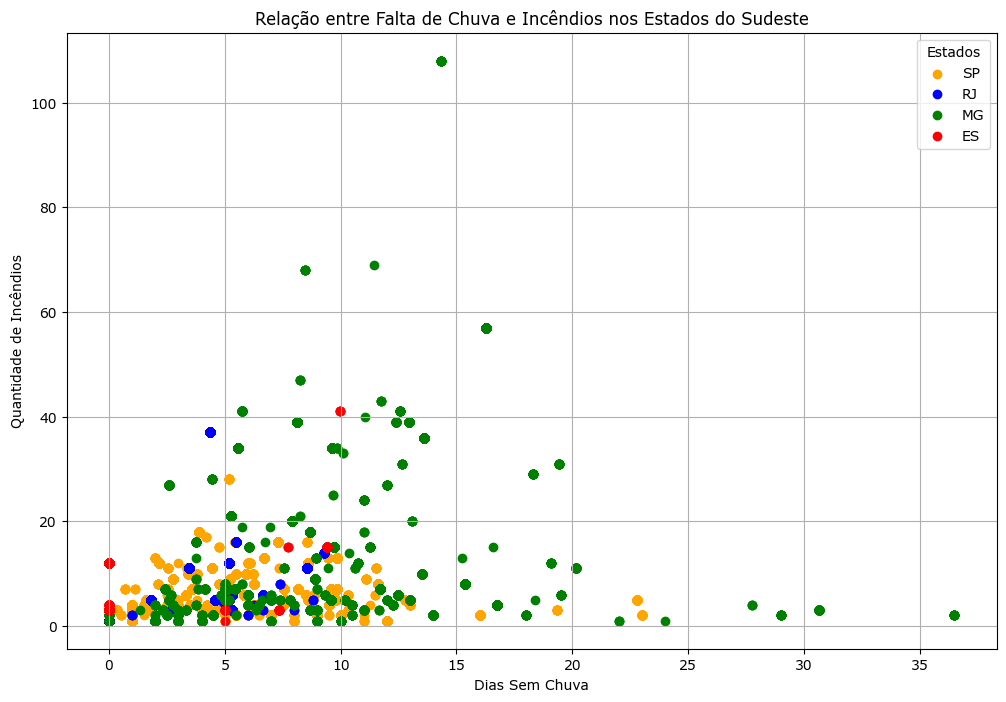

In [9]:
import matplotlib.pyplot as plt

# Definir as cores para cada estado
cores = {
    'SP': 'orange',
    'RJ': 'blue',
    'MG': 'green',
    'ES': 'red'
}

# Gráfico de Dispersão: Relação entre Falta de Chuva e Incêndios para todos os estados do Sudeste
plt.figure(figsize=(12, 8))

for estado in sudeste_estados:
    dados_estado = dados_sudeste[dados_sudeste['Estado'] == estado]
    plt.scatter(dados_estado['DiaSemChuva'], dados_estado['Incendios_Contagem'], color=cores[estado], label=estado)

plt.title('Relação entre Falta de Chuva e Incêndios nos Estados do Sudeste')
plt.xlabel('Dias Sem Chuva')
plt.ylabel('Quantidade de Incêndios')
plt.legend(title='Estados')
plt.grid()
plt.show()
